# Packages

You might also need to do `!pip install tdqm` (but, oddly, you don't have to import it). 
Okay you don't *need* to, but it gives you a loading bar, and i think lmfit gives you a nonfatal 
warning if you don't have it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import lmfit as lf
import emcee

# me generating random data
and the usual `lmfit` stuff

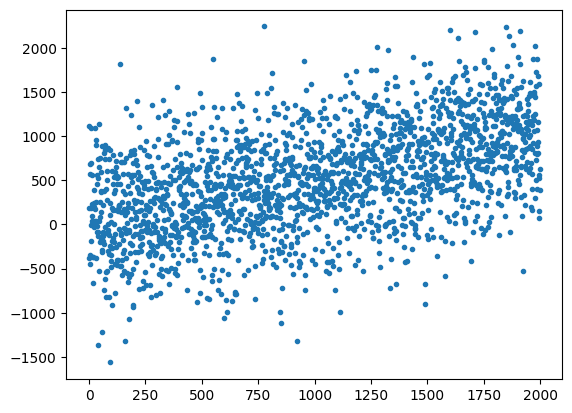

In [67]:
x = np.arange(0, 2000)
y = np.arange(0, 1000, 0.5) + np.random.normal(0,500,2000)
plt.plot(x, y, '.')

In [68]:
def linear(m, b, x):
    return m*x+b

linear_model = lf.Model(linear, independent_vars = 'x')

In [69]:
pars = linear_model.make_params()

# begin emcee stuff (soon)
I recommend using like leastsquares, nelder, or basinhopping to fit your function first, 
so you can get a good idea of what your parameters are. Then, **redefine your parameters**
with your updated upper and lower bounds, and set `value` equal to your best guess at the parameter.

In [98]:
pars.add('m', min = 0, max =1, value = 0.5)
pars.add('b', min = -10, max = 10, value = -8)

## this is *actually* the beginning of the emcee stuff
The three parameters listed below (`nwalkers`, `steps`, and `pos`) are specific to `emcee`.
- `nwalkers` is the number of Monte Carlo walkers that are computing you "loss" function at 
    each step. I think of them as "little dudes" that are wandering around in the space of possible
    parameter values (in this case, on a plane whose coordinates are "slope (m)" and "intercept (b)")
    trying to find the best spot.
- `steps` is the number of steps that you're giving them in order to find the best spot.
- and `pos` is an array of where the little dudes start. Notice the shape of the array:
    $n\_walkers \times num\_pars$

choose your own values for nwalkers and nsteps. I think in general `nwalkers` should be pretty high (200 is good),
and `steps` should be high enough that your parameters are converged. Don't make it *too* high, cuz then
it'll take 90 years to converge. What does converged mean? Well... If you run the following with 
`steps = 100`, then you'll probably get a warning that `The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s)`. Then, look at the plot of where the walkers walked (at the very bottom 
of this page). You'll probably see that the walkers have just *barely* agreed on a value of $m$. You 
want a stronger consensus between the little dudes.

In the block below, you'll see this `np.random.triangular` thing. In order to see what this distribution looks like, I've plotted the histograms of starting $m$ and $b$ below that. (along with the *triangular* probability density functions)

In [99]:
nwalkers = 200
steps = 1000
pos = np.zeros((nwalkers, len(pars)))
for i, par in enumerate(pars):
    pos[:, i] = np.random.triangular(left = pars[par].min, 
                                     mode = pars[par].value, right = pars[par].max, size=nwalkers)

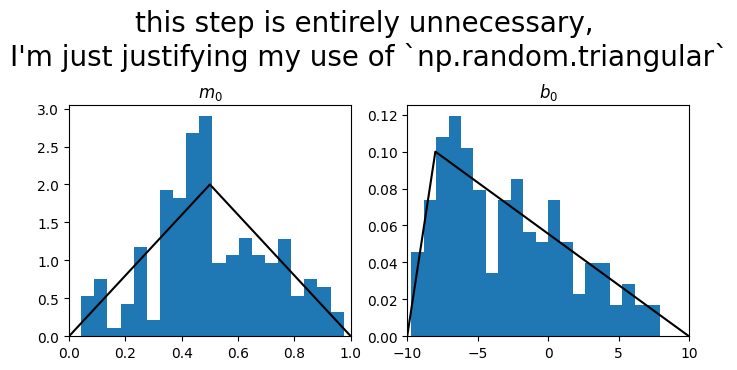

In [100]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.hist(pos[:, 0], bins=20, density=True)
plt.plot([pars['m'].min, pars['m'].value, pars['m'].max], [0, 2/(pars['m'].max - pars['m'].min), 0], 'k')
plt.xlim(pars['m'].min, pars['m'].max)
plt.title('$m_0$')


plt.subplot(122)
plt.hist(pos[:, 1], bins=20, density=True)
plt.plot([pars['b'].min, pars['b'].value, pars['b'].max], [0, 2/(pars['b'].max - pars['b'].min), 0], 'k')
plt.xlim(pars['b'].min, pars['b'].max)
plt.title('$b_0$')
plt.suptitle('this step is entirely unnecessary, \nI\'m just justifying my use of `np.random.triangular`',
             y=1.2,size=20)
plt.show()

In [101]:
result = linear_model.fit(data=y, params=pars, method='emcee', x=x,
                          fit_kws={'pos': pos, 'nwalkers': nwalkers, 'steps': steps}
                         )

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 229.03it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [11.5484872  24.95810922]


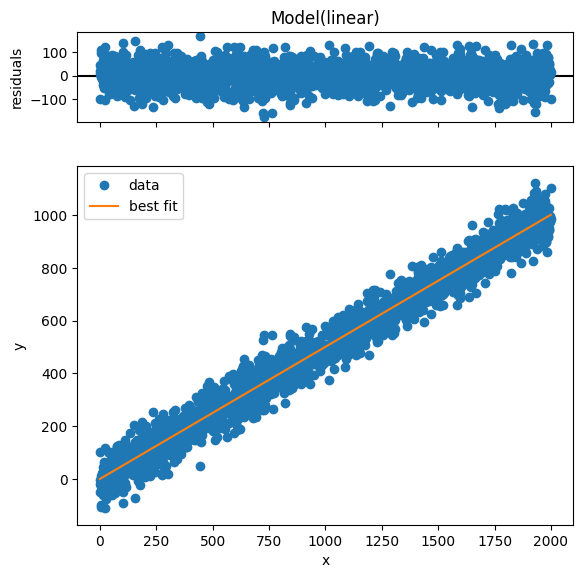

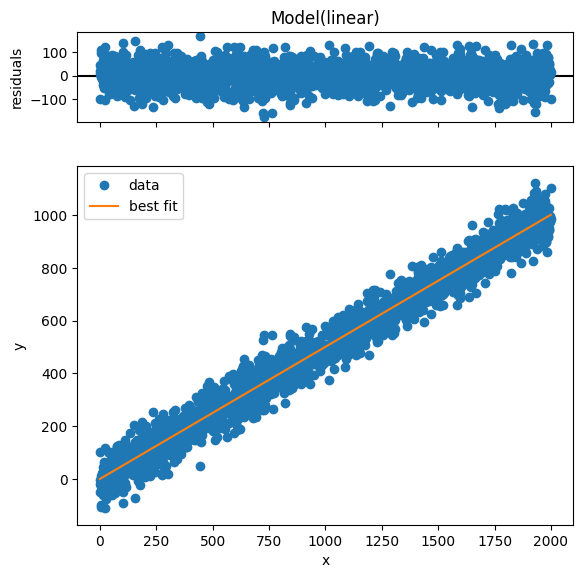

In [102]:
result.plot()

In [103]:
result

# New (April 28, 2023)
The "Akaike info crit." and "Bayesian info crit." (Akaike/Bayesian information criterion)
are useful for comparing two curve fits to the same dataset. I would use the Bayesian Information
Criterion over Akaike personally. I don't think it makes a huge difference, honestly, but I had
at one point convinced myself that the Bayesian one was better.

Anyways, you use the BIC to compare two fitting methods for the same dataset. For example, if you 
had results like:

|         | BIC: one_exp | BIC: two_exp |
| ------- | ------------ | ------------ |
| C25-C28 | 1000         | 1200         |
| C35-C38 | 500          | 100          |

then from just this information you could say the single exponential fit was better than the
double exponential fit for the C2_ chain, and that the double exponential fit was better for the
C3_ chain (because of the lower BICs. Lower is better here). However, you couldn't say that the fits 
were better in general for the C3_ chain than the C2_ chain, because those are different 
datasets.

# plot of the last few steps' fits
It's clearly converged: this plot has... 2000 lines on it (if you keep `nwalkers` at 200),
and they're all overlapping

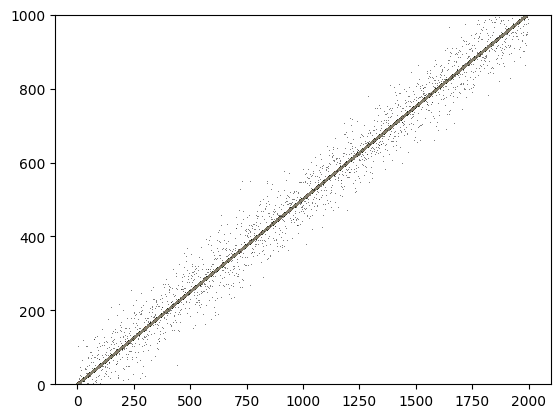

In [104]:
for s in range(10):
    for w in range(nwalkers):
        plt.plot(x, linear(*result.chain[-s-1, w, :], x), alpha = 0.1)
plt.ylim(0,1000)
plt.plot(x, y, 'k,', alpha = 0.5)

Text(0, 0.5, '$b$')

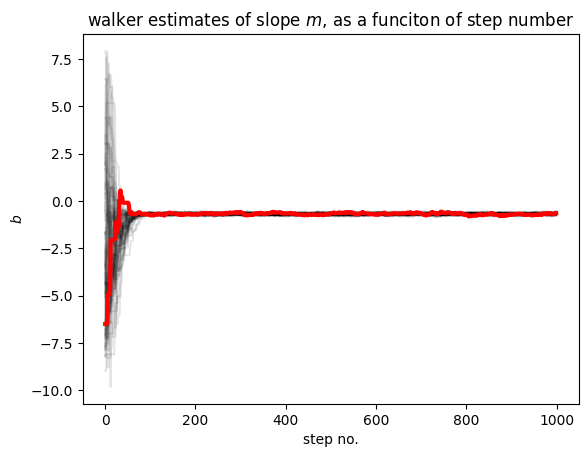

In [105]:
for w in range(1, 64):
    plt.plot(result.chain[:, w, 1], 'k', alpha = 0.1)
plt.plot(result.chain[:, 0, 1], 'r', alpha = 1, lw = 3)
# plt.ylim(0, 2)
# plt.ylim(0.49, 0.51)
# plt.ylim(-0.1, 0.5)
plt.title('walker estimates of slope $m$, as a funciton of step number')
plt.xlabel('step no.')
plt.ylabel('$b$')

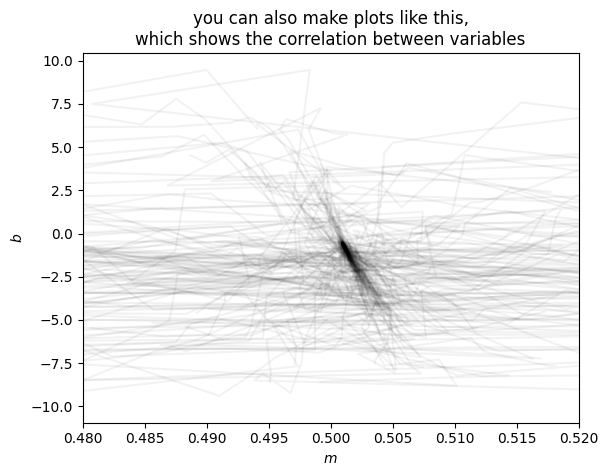

In [116]:
for w in range(1, nwalkers):
    plt.plot(result.chain[:, w, 0], result.chain[:, w, 1], 'k', alpha = 0.05)
plt.xlabel('$m$')
plt.ylabel('$b$')
plt.xlim(0.48, 0.52)
plt.title('you can also make plots like this,\nwhich shows the correlation between variables')
plt.show()

(-4.0, 4.0)

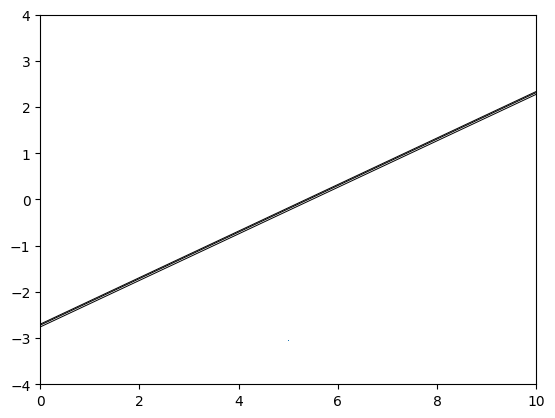

In [113]:
x = np.arange(0, 2000)
y = np.arange(0, 1000, 0.5) + np.random.normal(0,50,2000)
plt.plot(x, y, ',')
for _ in range(3):
    plt.plot(x, linear(np.random.normal(0.5035537, 0.00004), np.random.normal(-2.722, 0.05), x), 'k', lw = 0.7)
plt.xlim(0,10)
plt.ylim(-4, 4)